In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kaggle as kg
import os
import shutil
from tqdm.notebook import tqdm

In [2]:
# Importando o dataset
dataset_handle = "abdelghaniaaba/wildfire-prediction-dataset"
destination_path = "./datasets/wildfire-prediction"

os.makedirs(destination_path, exist_ok=True)

# Comentar bloco abaixo em reexecução

#print(f"Downloading dataset to '{destination_path}'...")

#kaggle_command = f'kaggle datasets download -d {dataset_handle} -p "{destination_path}" --unzip'
#print(f'Executing {kaggle_command}\n')

#os.system(kaggle_command)
print("Download Successful")


Download Successful


In [3]:
# Criando diretórios
unsplit_dataset = "./datasets/unsp_wildfire-prediction"
print(f"Unspliting the dataset in '{destination_path}'...")

final_wildfire_path = os.path.join(unsplit_dataset, 'wildfire')
final_no_wildfire_path = os.path.join(unsplit_dataset, 'nowildfire')

os.makedirs(final_wildfire_path, exist_ok=True)
os.makedirs(final_no_wildfire_path, exist_ok=True)

print(f"Folders created in '{unsplit_dataset}'\n")

Unspliting the dataset in './datasets/wildfire-prediction'...
Folders created in './datasets/unsp_wildfire-prediction'



In [5]:
total_files_moved = 0
split_folders = ['train', 'test', 'valid']

for split in split_folders:
    for class_name in ['wildfire', 'nowildfire']:
        source_folder = os.path.join(destination_path, split, class_name)
        destination_folder = os.path.join(unsplit_dataset, class_name)

        if not os.path.isdir(source_folder):
            print(f"Warning: Source folder not found, skipping: {source_folder}")
            continue

        files = os.listdir(source_folder)

        for file_name in tqdm(files, desc=f"Moving from {split}/{class_name}"):
            new_file_name = f"{split}_{file_name}"

            source_file_path = os.path.join(source_folder, file_name)
            destination_file_path = os.path.join(destination_folder, new_file_name)

            shutil.move(source_file_path, destination_file_path)
            total_files_moved += 1

print(f"Process done! Total of {total_files_moved} files moved.")
print(f"Unsplited dataset is at '{unsplit_dataset}'.")

Unspliting the dataset in './datasets/wildfire-prediction'...
Folders created in './datasets/unsp_wildfire-prediction'



Moving from valid/nowildfire: 100%|██████████████████████████████████████████████| 2820/2820 [00:00<00:00, 3220.41it/s]

Process done! Total of 42850 files moved.
Unsplited dataset is at './datasets/unsp_wildfire-prediction'.


In [4]:
# Indo para o processo de extração de características
from desc_imagens.lbp import lbp
from desc_imagens.glcm import glcm
import cv2
from joblib import Parallel, delayed, dump


wildfire_files = os.listdir(final_wildfire_path)
no_wildfire_files = os.listdir(final_no_wildfire_path)
output_folder = './output/output_features'
os.makedirs(output_folder, exist_ok=True)

features_file = os.path.join(output_folder, 'features_lbp.npy')
labels_file = os.path.join(output_folder, 'labels_lbp.npy')


In [5]:
def process_image(img_path, label, desc='lbp'):
    image_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image_gray is not None:
        if desc == 'lbp':
            feature_vector = lbp(image_gray)
        elif desc == 'glcm':
            feature_vector = glcm(image_gray)
        elif desc == 'lpq':
            feature_vector = glcm(image_gray)
        else:
            return None, None
        return feature_vector, label
    return None, None

In [6]:
# Separando as classes e criando tarefas a serem processadas

tasks = []
classes = {
    'wildfire': 1,
    'nowildfire': 0
}


print(f'Preparing processing task list...')
for class_name, label  in classes.items():
    class_path = os.path.join(unsplit_dataset, class_name)
    image_files = os.listdir(class_path)
    for file_name in image_files:
        tasks.append((os.path.join(class_path, file_name), label))

print(f"Total of {len(tasks)} images to process.")

Preparing processing task list...
Total of 42850 images to process.


In [15]:
# Extraindo características usando LBP e 
# salvando as features e as labels referentes em './output/output_features'


print("Starting feature extraction...")

# Usando todos os núcleos do CPU
results = Parallel(n_jobs=-1)(
    delayed(process_image)(path, lbl) for path, lbl in tqdm(tasks) 
)

print("\nSpliting features and labels...")
features = []
labels = []

for feature, label in results:
    if feature is not None:
        features.append(feature)
        labels.append(label)

# Convertendo as listas em numpy arrays
print("Converting to numpy array and saving...")

X = np.array(features)
y = np.array(labels)

print(f'Features array dimension (X): {X.shape}')
print(f'Labels array dimension (y): {y.shape}')

print(f"Saving the arrays in '{output_folder}'...")
np.save(features_file, X)
np.save(labels_file, y)
print(f"Files saved: \n- {features_file}\n- {labels_file}")

Preparing processing task list...
Total of 42850 images to process.
Starting feature extraction...


  0%|          | 0/42850 [00:00<?, ?it/s]


Spliting features and labels...
Converting to numpy array and saving...
Features array dimension (X): (42850, 59)
Labels array dimension (y): (42850,)
Saving the arrays in './output/output_features'...
Files saved: 
- ./output/output_features\features_lbp.npy
- ./output/output_features\labels_lbp.npy


In [5]:
# Lendo arrays salvas nas outputs
print('Loading features and labels...')

X = np.load(features_file)
print(f'Features array dimension (X): {X.shape}')
y = np.load(labels_file)
print(f'Labels array dimension (y): {y.shape}')


Loading features and labels...
Features array dimension (X): (42850, 59)
Labels array dimension (y): (42850,)


In [9]:
# Importando modelos e utilitários
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Criando uma pasta para salvar os plots
plots_folder = './output/output_plots'
os.makedirs(plots_folder, exist_ok=True)

# Criando uma pasta para salvar os modelos treinados
models_folder = './output/output_models'
os.makedirs(models_folder, exist_ok=True)


# SVM com LBP

Data split into 34280 train samples and 8570 test samples.

Optimizing SVM with GridSearchCV and k=5...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparams found: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Saving best trained model in './output/output_models\svm_lbp.joblib'...
Model saved successfuly!

---Testing process ---

1. Metrics:
              precision    recall  f1-score   support

  nowildfire       0.89      0.86      0.87      4006
    wildfire       0.88      0.90      0.89      4564

    accuracy                           0.88      8570
   macro avg       0.88      0.88      0.88      8570
weighted avg       0.88      0.88      0.88      8570


2. Confusion Matrix:
Confusion Matrix saved at './output/output_plots\matriz_confusao_svm_lbp.png...'


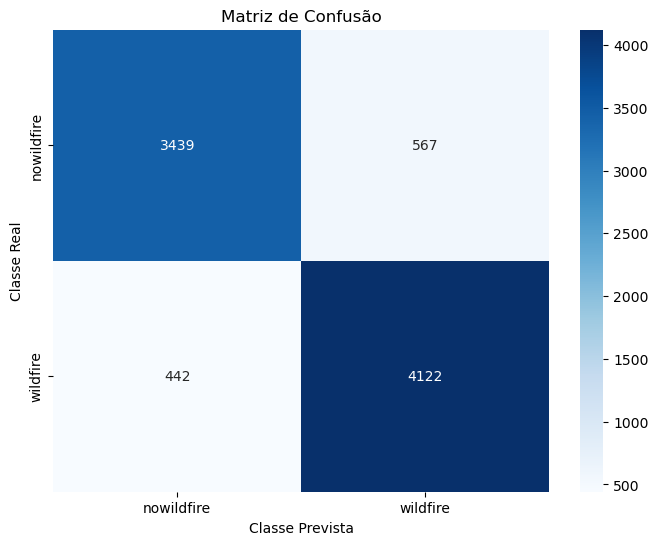

In [13]:
# Separando conjunto de teste e treino (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'Data split into {len(X_train)} train samples and {len(X_test)} test samples.')

# Começando processo de otimização e avalização por validação cruzada

print("\nOptimizing SVM with GridSearchCV and k=5...")
model_svc = SVC(probability=True)
svc_param_grid = {
    'C': [1,10,100],
    'gamma': [0.1, 0.01],
    'kernel': ['rbf']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model_svc, svc_param_grid, cv=cv_strategy, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Pegando o melhor modelo obtido pela validação cruzada
best_model = grid_search.best_estimator_

model_filename = os.path.join(models_folder, 'svm_lbp.joblib')
print(f"Best hyperparams found: {grid_search.best_params_}")
print(f"\nSaving best trained model in '{model_filename}'...")
dump(best_model, model_filename)
print("Model saved successfuly!")


print("\n---Testing process ---")

y_pred = best_model.predict(X_test)

print("\n1. Metrics:")
class_names = ['nowildfire', 'wildfire']
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

print("\n2. Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')

output_plot_path = os.path.join(plots_folder, 'matriz_confusao_svm_lbp.png')
plt.savefig(output_plot_path, dpi=300)
print(f"Confusion Matrix saved at '{output_plot_path}...'")

plt.show()

# Comentários (SVM + LBP)

Com os parâmetros sendo definidos em `{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}` tivemos uma média de 88% no F1-Score. Algo interessante de se ter em conta é que o algoritmo tem um desempenho melhor em identificar zonas que estão queimadas do que zonas que não estão (visto que ele acertou 89% das zonas queimadas e 87% da zonas não queimadas), observando a matriz de confusão, vemos que tivemos um número maior de falsos positivos do que falsos negativos, comparando os valores de *precision* que é aproximadamente 88% e *recall* que é 90%, vemos que ambos são bem proximos, evidenciando um bom balanço, o que indica que o modelo não está simplesmente "chutando" a classe majoritária e que ele de fato identificou os padrões de forma eficaz.

---

# SVM com GLCM

In [7]:
# Testando com GLCM
features_file_glcm = os.path.join(output_folder, 'features_glcm.npy')
labels_file_glcm = os.path.join(output_folder, 'labels_glcm.npy')

print("Extracting by GLCM...")
results_glcm = Parallel(n_jobs=-1)(
    delayed(process_image)(path, lbl, 'glcm') for path, lbl in tqdm(tasks) 
)

print("\nSpliting features and labels...")
features_glcm = []
labels_glcm = []

for feature, label in results_glcm:
    if feature is not None:
        features_glcm.append(feature)
        labels_glcm.append(label)

# Convertendo as listas em numpy arrays
print("Converting to numpy array and saving...")

X_glcm = np.array(features_glcm)
y_glcm = np.array(labels_glcm)

print(f'Features array dimension (X): {X_glcm.shape}')
print(f'Labels array dimension (y): {y_glcm.shape}')

print(f"Saving the arrays in '{output_folder}'...")
np.save(features_file_glcm, X_glcm)
np.save(labels_file_glcm, y_glcm)
print(f"Files saved: \n- {features_file_glcm}\n- {labels_file_glcm}")

Extracting by GLCM...


  0%|          | 0/42850 [00:00<?, ?it/s]


Spliting features and labels...
Converting to numpy array and saving...
Features array dimension (X): (42850, 72)
Labels array dimension (y): (42850,)
Saving the arrays in './output/output_features'...
Files saved: 
- ./output/output_features\features_glcm.npy
- ./output/output_features\labels_glcm.npy


In [8]:
# Lendo arrays salvas nas outputs
print('Loading features and labels...')

X_glcm = np.load(features_file_glcm)
print(f'Features array dimension (X_glcm): {X_glcm.shape}')
y_glcm = np.load(labels_file_glcm)
print(f'Labels array dimension (y_glcm): {y_glcm.shape}')

Loading features and labels...
Features array dimension (X_glcm): (42850, 72)
Labels array dimension (y_glcm): (42850,)


Data split into 34280 train samples and 8570 test samples.

Optimizing SVM with GridSearchCV and k=5...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparams found: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Saving best trained model in './output/output_models\svm_glcm.joblib'...
Model saved successfuly!

---Testing process ---

1. Metrics:
              precision    recall  f1-score   support

  nowildfire       0.70      0.04      0.07      4039
    wildfire       0.53      0.98      0.69      4531

    accuracy                           0.54      8570
   macro avg       0.62      0.51      0.38      8570
weighted avg       0.61      0.54      0.40      8570


2. Confusion Matrix:
Confusion Matrix saved at './output/output_plots\matriz_confusao_svm_glcm.png...'


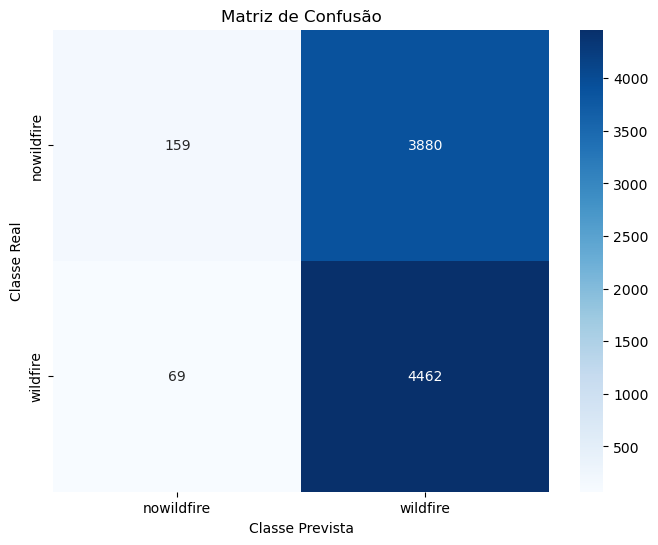

In [12]:
# Separando conjunto de teste e treino (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X_glcm, y_glcm, test_size=0.2)
print(f'Data split into {len(X_train)} train samples and {len(X_test)} test samples.')

# Otimizando hiperparametros e usando cross-validation com StratifiedKFold e GridSearch
print("\nOptimizing SVM with GridSearchCV and k=5...")
model_svc = SVC(probability=True)
svc_param_grid = {
    'C': [1,10,100],
    'gamma': [0.1, 0.01],
    'kernel': ['rbf']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model_svc, svc_param_grid, cv=cv_strategy, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Pegando o melhor modelo obtido pela validação cruzada
best_model = grid_search.best_estimator_

model_filename = os.path.join(models_folder, 'svm_glcm.joblib')
print(f"Best hyperparams found: {grid_search.best_params_}")
print(f"\nSaving best trained model in '{model_filename}'...")
dump(best_model, model_filename)
print("Model saved successfuly!")


print("\n---Testing process ---")

y_pred = best_model.predict(X_test)

print("\n1. Metrics:")
class_names = ['nowildfire', 'wildfire']
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

print("\n2. Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')

output_plot_path = os.path.join(plots_folder, 'matriz_confusao_svm_glcm.png')
plt.savefig(output_plot_path, dpi=300)
print(f"Confusion Matrix saved at '{output_plot_path}...'")

plt.show()

# Comentários (SVM + GLCM #1)
Tivemos uma acurácia muito baixa dessa vez usando o **GLCM**, de apenas 54%, analisando a Matriz de Confusão, podemos concluir que o modelo na realidade chutou a classe majoritária diversas vezes, explicando o número elevado de falsos positivos e a desproporcionalidade entre o *recall* e a *precision*. Uma das possíveis causas para isto talvez seja a escala dos valores obtidos pelo *GLCM*, uma próxima abordagem tentando padronizar/colocar os dados na mesma escala será tomada. Outra análise a se fazer sobre é que o uso da GLCM aumentou a complexidade computacional para o treinamento da SVM, levando aproximadamente 3 horas para concluir seu treino em uma máquina com um processador com teto de frequência de 4.1GHz, 8 núcleos e 16 threads, enquanto usando o LBP, ela levou aproximadamente 15 minutos para concluir o treino sobre as mesmas condições.

---

# Random Forest com LBP

In [14]:
# Lendo as features e labels extraídas por LBP
print("Loading features and labels from LBP...")
X = np.load(features_file)
y = np.load(labels_file)
print("Data loaded.")

# Dividindo o conjunto novamente em treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print(f"Data split into {len(X_train)} train samples and {len(X_test)} test samples.")

Loading features and labels from LBP...
Data loaded.
Data split into 34280 train samples and 8570 test samples.


In [16]:
# Importando o modelo
from sklearn.ensemble import RandomForestClassifier

print("\n--- Optimizing Random Forest with GridSearchCV (k=5) ---")

# Usando todos os núcleos para paralelizar a construção das árvores.
model_rf_lbp = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grade de parâmetros para testar.
param_grid_rf = {
    'n_estimators': [100, 200, 300], # Número de árvores na floresta 
    'max_depth': [10, 20, 30], # Profundidade máxima das árvores
    'min_samples_leaf': [1, 2, 4] # Mínimo de amostras em um nó folha
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf_lbp  = GridSearchCV(
    estimator=model_rf_lbp,
    param_grid=param_grid_rf,
    cv=cv_strategy,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_rf_lbp.fit(X_train, y_train)

print('\n--- Results of the Optimization ---')
print(f"Best hyperparams for the Random Forest: {grid_rf_lbp.best_params_}")
print(f"Best accuracy in the cross-validation: {grid_rf_lbp.best_score_:.4f}")

print("\n--- FINAL TEST FOR THE RANDOM FOREST IN THE TEST SET ---")

best_rf_model_lbp = grid_rf_lbp.best_estimator_
y_pred_rf_lbp = best_rf_model_lbp.predict(X_test)



--- Optimizing Random Forest with GridSearchCV (k=5) ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

--- Results of the Optimization ---
Best hyperparams for the Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 300}
Best accuracy in the cross-validation: 0.9496

--- FINAL TEST FOR THE RANDOM FOREST IN THE TEST SET ---

Saving best trained model in './output/output_models\rf_lbp.joblib'...

1. Metrics:
              precision    recall  f1-score   support

  nowildfire       0.95      0.94      0.95      4050
    wildfire       0.95      0.96      0.95      4520

    accuracy                           0.95      8570
   macro avg       0.95      0.95      0.95      8570
weighted avg       0.95      0.95      0.95      8570


2. Confusion Matrix:


NameError: name 'y_pred_rf' is not defined

In [18]:
# Salvando o modelo
model_filename = os.path.join(models_folder, 'rf_lbp.joblib')
print(f"\nSaving best trained model in '{model_filename}'...")
dump(best_rf_model_lbp, model_filename)
print("Model saved successfuly!")


Saving best trained model in './output/output_models\rf_lbp.joblib'...
Model saved successfuly!



1. Metrics:
              precision    recall  f1-score   support

  nowildfire       0.95      0.94      0.95      4050
    wildfire       0.95      0.96      0.95      4520

    accuracy                           0.95      8570
   macro avg       0.95      0.95      0.95      8570
weighted avg       0.95      0.95      0.95      8570


2. Confusion Matrix:
Confusion Matrix saved at './output/output_plots\matriz_confusao_rf_lbp.png...'


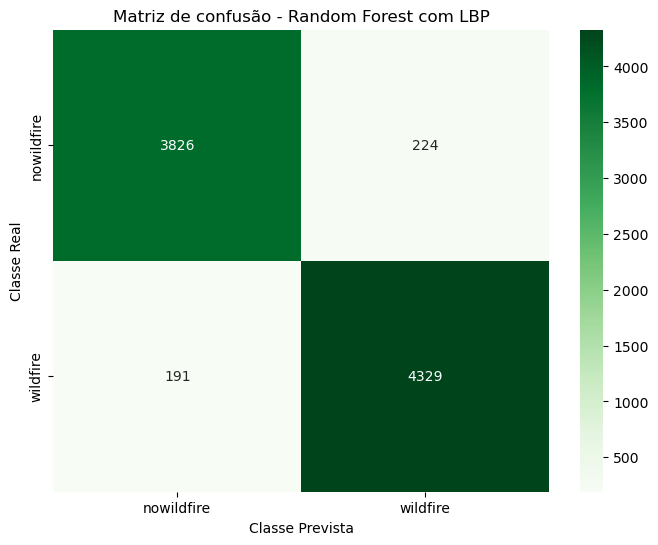

In [17]:
print("\n1. Metrics:")
report_rf = classification_report(y_test, y_pred_rf_lbp, target_names=class_names)
print(report_rf)

print("\n2. Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_lbp)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusão - Random Forest com LBP')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
output_plot_path = os.path.join(plots_folder, 'matriz_confusao_rf_lbp.png')
plt.savefig(output_plot_path, dpi=300)
print(f"Confusion Matrix saved at '{output_plot_path}...'")

plt.show()

# Comentários - Random Forest com LBP
Esse modelo apresentou um desempenho excelente usando os parâmetros `{'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 300}` encontrados pelo cross-validation, não há desbalanço entre *precision* e *recall* (95% e ~96% respectivamente), provando que o modelo não fez chutes na classe majoritária e que aprendeu corretamente os padrões para classificar os dados. Quanto ao desempenho superior em relação a SVM, isto pode dizer muito sobre os dados, o LBP pode ter gerado um espaço de características onde a separação das classe se mostra complexa e não-linear, o qual a Random Forest se mostrou mais flexível sobre do que a SVM, outro fator que pode ter influenciado é que a SVM é bem mais sensível aos hiperparâmetros, pode ser que alguma outra variação de parâmetros desempenhasse melhor.

---

# Random Forest com GLCM

In [20]:
# Lendo as features e labels extraídas por GLCM
print("Loading features and labels from GLCM...")
X = np.load(features_file_glcm)
y = np.load(labels_file_glcm)
print("Data loaded.")

# Dividindo o conjunto novamente em treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print(f"Data split into {len(X_train)} train samples and {len(X_test)} test samples.")

Loading features and labels from GLCM...
Data loaded.
Data split into 34280 train samples and 8570 test samples.


In [21]:
print("\n--- Optimizing Random Forest with GridSearchCV (k=5) ---")

# Usando todos os núcleos para paralelizar a construção das árvores.
model_rf_glcm = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grade de parâmetros para testar.
param_grid_rf = {
    'n_estimators': [100, 200, 300], # Número de árvores na floresta 
    'max_depth': [10, 20, 30], # Profundidade máxima das árvores
    'min_samples_leaf': [1, 2, 4] # Mínimo de amostras em um nó folha
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf_glcm  = GridSearchCV(
    estimator=model_rf_lbp,
    param_grid=param_grid_rf,
    cv=cv_strategy,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_rf_glcm.fit(X_train, y_train)

print('\n--- Results of the Optimization ---')
print(f"Best hyperparams for the Random Forest: {grid_rf_glcm.best_params_}")
print(f"Best accuracy in the cross-validation: {grid_rf_glcm.best_score_:.4f}")

print("\n--- FINAL TEST FOR THE RANDOM FOREST IN THE TEST SET ---")

best_rf_model_glcm = grid_rf_glcm.best_estimator_
y_pred_rf_glcm = best_rf_model_glcm.predict(X_test)



--- Optimizing Random Forest with GridSearchCV (k=5) ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

--- Results of the Optimization ---
Best hyperparams for the Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 200}
Best accuracy in the cross-validation: 0.9383

--- FINAL TEST FOR THE RANDOM FOREST IN THE TEST SET ---


In [22]:
# Salvando o modelo
model_filename = os.path.join(models_folder, 'rf_glcm.joblib')
print(f"\nSaving best trained model in '{model_filename}'...")
dump(best_rf_model_glcm, model_filename)
print("Model saved successfuly!")


Saving best trained model in './output/output_models\rf_glcm.joblib'...
Model saved successfuly!



1. Metrics:
              precision    recall  f1-score   support

  nowildfire       0.94      0.93      0.94      4056
    wildfire       0.94      0.95      0.94      4514

    accuracy                           0.94      8570
   macro avg       0.94      0.94      0.94      8570
weighted avg       0.94      0.94      0.94      8570


2. Confusion Matrix:
Confusion Matrix saved at './output/output_plots\matriz_confusao_rf_glcm.png...'


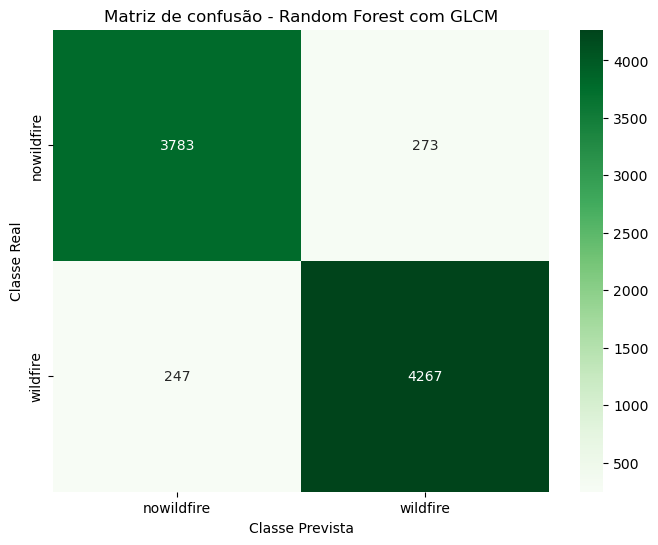

In [23]:
print("\n1. Metrics:")
report_rf = classification_report(y_test, y_pred_rf_glcm, target_names=class_names)
print(report_rf)

print("\n2. Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_glcm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusão - Random Forest com GLCM')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
output_plot_path = os.path.join(plots_folder, 'matriz_confusao_rf_glcm.png')
plt.savefig(output_plot_path, dpi=300)
print(f"Confusion Matrix saved at '{output_plot_path}...'")

plt.show()

# Comentários - Random Forest com GLCM
A performance desse modelo também foi muito boa, foi um pouco inferior à versão com LBP, o que neste caso pode ter sido apenas uma coincidência devido a divisão dos dados, mas também pode apresentar uma leve vantagem do LBP em relação ao GLCM, com a capacidade do LBP em identificar **micro-padrões** talvez mostrando-se melhor para identificar regiões queimadas. O GLCM eleva a complexidade do conjunto de características formado, e como citado anteriormente, a Random Forest lida bem com isso, enquanto a SVM com a versão não escalonada do GLCM se mostrou nem um pouco performática. 

---

# SVM com GLCM Escalonado

In [24]:
# Lendo as features e labels extraídas por GLCM
from sklearn.preprocessing import StandardScaler

print("Loading features and labels from GLCM...")
X = np.load(features_file_glcm)
y = np.load(labels_file_glcm)
print("Data loaded.")

# Dividindo o conjunto novamente em treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print(f"Data split into {len(X_train)} train samples and {len(X_test)} test samples.")

print("Scaling data (StandardScaler)...")
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data scaled!")

Loading features and labels from GLCM...
Data loaded.
Data split into 34280 train samples and 8570 test samples.
Scaling data (StandardScaler)...
Data scaled!


In [26]:
# Otimizando hiperparametros e usando cross-validation com StratifiedKFold e RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

print("\nOptimizing SVM with RandomizedSearchCV and StratifiedKFold k=5...")
model_svc = SVC(probability=True)
param_distributions = {
    'C': [1,10,100, 1000],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_svm = RandomizedSearchCV(
    estimator=model_svc,
    param_distributions=param_distributions, 
    n_iter=10,
    cv=cv_strategy,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
) 
random_search_svm.fit(X_train_scaled, y_train)

# Pegando o melhor modelo obtido pela validação cruzada
best_model = random_search_svm.best_estimator_

print('\n--- Results of the Optimization ---')
print(f"Best hyperparams for the SVM: {random_search_svm.best_params_}")
print(f"Best accuracy in the cross-validation: {random_search_svm.best_score_:.4f}")


Optimizing SVM with RandomizedSearchCV and StratifiedKFold k=5...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Results of the Optimization ---
Best hyperparams for the SVM: {'kernel': 'rbf', 'gamma': 0.01, 'C': 1000}
Best accuracy in the cross-validation: 0.9580


In [27]:
model_filename = os.path.join(models_folder, 'svm_glcm_scaled.joblib')
print(f"\nSaving best trained model in '{model_filename}'...")
dump(best_model, model_filename)
print("Model saved successfuly!")


Saving best trained model in './output/output_models\svm_glcm_scaled.joblib'...
Model saved successfuly!



--- Classification Results (WITH SCALED DATA) ---

1. Metrics:
              precision    recall  f1-score   support

  nowildfire       0.96      0.94      0.95      4033
    wildfire       0.95      0.96      0.96      4537

    accuracy                           0.95      8570
   macro avg       0.95      0.95      0.95      8570
weighted avg       0.95      0.95      0.95      8570


2. Confusion Matrix:
Confusion Matrix saved at './output/output_plots\matriz_confusao_svm_glcm_scaled.png...'


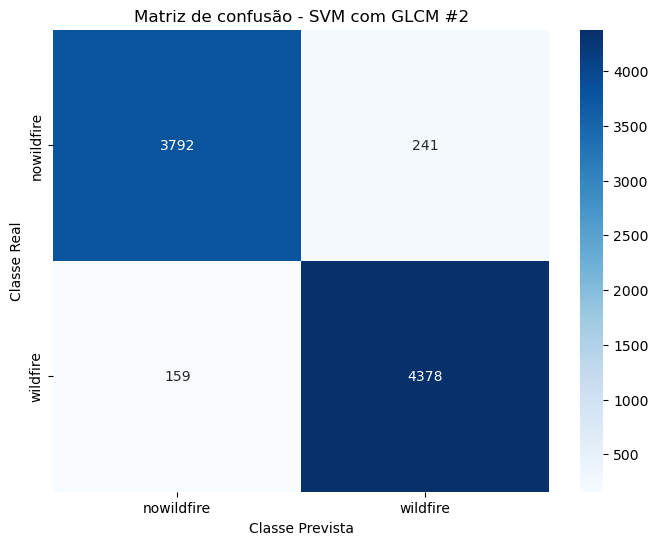

In [28]:
y_pred = best_model.predict(X_test_scaled)

print("\n--- Classification Results (WITH SCALED DATA) ---")

print("\n1. Metrics:")
report_rf = classification_report(y_test, y_pred, target_names=class_names)
print(report_rf)

print("\n2. Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusão - SVM com GLCM #2')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
output_plot_path = os.path.join(plots_folder, 'matriz_confusao_svm_glcm_scaled.png')
plt.savefig(output_plot_path, dpi=300)
print(f"Confusion Matrix saved at '{output_plot_path}...'")

plt.show()

# Comentários - (SVM com GLCM #2)

Este modelo apresentou um desempenho equivalente ao *Random Forest com LBP*, podemos levar em consideração os seguintes aspectos para tal ocorrência:
- De fato os valores não estarem escalonados antes prejudicaram muito a SVM, visto que esta se baseia na distância dos pontos, e escalas desproporcionais definitivamente afetam a forma que a SVM enxerga eles.
- Os hiperparâmetros selecionados podem ter influênciado o desempenho da versão anterior e da versão LBP também. Desta vez eu decidi por aumentar o intervalos de Cs e *gammas* para a *cross-validation*, por fim, a melhor combinação acabou sendo `{'kernel': 'rbf', 'gamma': 0.01, 'C': 1000}`, com um C maior que a versão anterior, implicando em uma menor tolerância a erros por parte da SVM.